In [1]:
import emcee
import numpy as np
from scipy import stats
import chainconsumer 
from cobaya.run import run
import matplotlib.pyplot as plt
from scipy.integrate import quad
from chainconsumer import ChainConsumer

%config InlineBackend.figure_format = 'svg'

In [2]:
# Load table
csv_table = np.loadtxt('data.csv', skiprows=1, delimiter=',', dtype='S', usecols=(1, 2, 3))


redshifts = csv_table[:, 0].astype(np.float) # redshifts

f_gas_colSCDM = np.array([np.array(i.split()).astype(np.float) for i in csv_table[:, 1]]) # SCDM column
f_gas_SCDM, sigma_SCDM = f_gas_colSCDM[:, 0], f_gas_colSCDM[:, 1]

f_gas_colLambdaCDM = np.array([np.array(i.split()).astype(np.float) for i in csv_table[:, 2]]) # LambdaCDM column
f_gas_LambdaCDM, sigma_LambdaCDM = f_gas_colLambdaCDM[:, 0], f_gas_colLambdaCDM[:, 1]

# Create dictionary from table data
data = {}
data['z'] = redshifts
data['f_gas_SCDM'] = f_gas_SCDM
data['sigma_SCDM'] = sigma_SCDM

data['f_gas_LambdaCDM'] = f_gas_LambdaCDM
data['sigma_LambdaCDM'] = sigma_LambdaCDM

In [3]:
# # Print data as a table
# print('z          f_gas_SCDM     f_gas_LambdaCDM')

# for i in range(len(data['z'])):
#     print('{}     {}+/-{}     {}+/-{}'.format(data['z'][i], data['f_gas_SCDM'][i], data['sigma_SCDM'][i], 
#                                           data['f_gas_LambdaCDM'][i], data['sigma_LambdaCDM'][i]))

In [4]:
def E_z(z, pars):
    omega_m = pars['omega_m']
    omega_X = pars['omega_X']
    omega_K = pars['omega_K']
    w_X = pars['w_X']
    f_z = (1+z)**(3*(1+w_X))
    return np.sqrt(omega_m*(1+z)**3 + omega_X*f_z + omega_K*(1+z)**2)

def one_over_E_z(z, pars):
    return 1/E_z(z, pars)

def d_A(z, pars):
    H0 = pars['h']*100
    
    c = 299792.458 # c in km/s
    
    integral = quad(one_over_E_z, 0, z, args=(pars))[0]
    if pars['omega_K']==0.:
        pre_factor = c/(H0*(1+z))
        return pre_factor*integral
    if pars['omega_K']>0.:
        pre_factor = c/(H0*(1+z)*pars['omega_K']**0.5)
        return pre_factor*np.sinh(pars['omega_K']**0.5*integral)

def f_model(z, pars):
    '''
    SCDM cosmology: omega_m = 1., h=0.5, omega_K=omega_X=0
    '''
    d_SCDM = d_A(z, {'omega_m':1., 'omega_X':0., 'omega_K':0., 'h':0.5, 'w_X':0.}) #reference cosmology 1
#     d_lambdaCDM = d_A(z, omega_m=.3, omega_X=0.7, omega_K=0., h=0.7, w_X=0.) #reference cosmology 2
    
    d_model = d_A(z, pars)
    
    return pars['b']*pars['omega_b']/((1 + 0.19*pars['h']**0.5)*pars['omega_m']) * (d_SCDM/d_model)**1.5
    

def log_prior(pars):
    '''
    Input: Parameter dictionary 
    Output: np.inf if parameter value out of bounds
            else Gaussian parameter prior
    '''
    count = 0
    for name, value in pars.items():
        limits = parameter_limits[name]
        low, high = limits[0], limits[1]
        if value< low or value>high:
            count+=1
    if count!=0:
        return -np.inf
    else : 
        return ((pars['omega_b']*pars['h']**2-0.0214)/0.002)**2 + ((pars['h']-0.72)/0.08)**2 
    + ((pars['b']-0.824)/0.089)**2
    
    
def log_likelihood(fit_par_values, fit_par_names):
    # f_gas data
    z, f_gas, f_gas_sigma = data['z'], data['f_gas_SCDM'], data['sigma_SCDM']
    
    pars = get_default_parameters()
    
    for par_value, par_name in zip(fit_par_values, fit_par_names):
        pars[par_name] = par_value
    
    log_likelihood = 0.
    
    for  z_i, f_gas_i, f_gas_sigma_i in zip(z, f_gas, f_gas_sigma):        
        f_gas_model = f_model(z_i, pars)
        log_likelihood += (f_gas_i - f_gas_model)**2/f_gas_sigma_i**2
    
    if not np.isfinite(log_prior(pars)):
        return -np.inf
    else:
        return -log_likelihood - log_prior(pars)
    

In [5]:
def get_default_parameters(update=None):
    pars = {}
    pars['omega_m'] = 0.3
    pars['omega_X'] = 0.7
    pars['omega_K'] = 0.01
    pars['omega_b'] = 0.05
    pars['h'] = 0.72
    pars['w_X'] = 0.
    pars['b'] = 0.8
    if update is not None:
        pars.update(update)
    return pars

def get_starting_point(name_list):
    sp = {}
    sp['omega_m'] = 0.3
    sp['omega_X'] = 0.7
    sp['omega_K'] = 0.01
    sp['omega_b'] = 0.05
    sp['h'] = 0.72
    sp['w_X'] = 0.1
    sp['b'] = 0.8
    
    return np.array([sp[x] for x in name_list])
    
    
    
def get_latex_names(name_list):
    latex_names = {}
    latex_names['omega_m'] = '$\Omega_m$'
    latex_names['omega_X'] = '$\Omega_X$'
    latex_names['omega_K'] = '$\Omega_K$'
    latex_names['omega_b'] = '$\Omega_b$'
    latex_names['h'] = 'h'
    latex_names['w_X'] = 'w_X'
    latex_names['b'] = 'b'
    
    return [latex_names[x] for x in name_list]


parameter_limits={
    'omega_m' : [0., 1.],
    'omega_X' : [0., 1.],
    'omega_K' : [0., 1.],
    'omega_b' : [0., 1.],
    'h'       : [.2, 1.],
    'w_X'     : [-3., 3.],
    'b'       : [0., 1.]
    }

In [6]:
fit_par_names = ['b'] #['omega_m', 'omega_X', 'omega_K', 'omega_b', 'h', 'b']

starting_point = get_starting_point(fit_par_names)
std = 0.1*starting_point
ndim = len(fit_par_names)
nwalkers = 32

p0 = emcee.utils.sample_ball(starting_point, std, size=nwalkers)

In [7]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_likelihood, args=[fit_par_names])
sampler.run_mcmc(p0, 2000, progress=True);

100%|██████████| 2000/2000 [02:29<00:00, 13.42it/s]


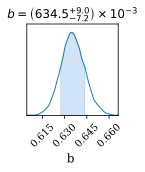

In [8]:
samples = sampler.get_chain(discard=1000, flat=True)
par_names_latex = get_latex_names(fit_par_names)
c = ChainConsumer().add_chain(samples, parameters=par_names_latex).configure(statistics="max", summary=True,usetex=False)
fig = c.plotter.plot()


## Check if angular diameter distance is caluclated correctly

In [ ]:
import astropy.cosmology as cosmo
import astropy.units as u
cosm = cosmo.wCDM(H0=69.6*u.km / u.s / u.Mpc, Om0=0.286, Ode0=0.714, w0=0)
cosm.angular_diameter_distance(3)

In [ ]:
d_A(z=3, omega_m=0.286, omega_X=0.714, omega_K=0.0, h=0.696, w_X=0.)

## Figures

In [ ]:
# Fig. 2(a)
plt.figure()
plt.scatter(data['z'], data['f_gas_SCDM'], c='black')
plt.errorbar(data['z'], data['f_gas_SCDM'],yerr=data['sigma_SCDM'], linestyle="None", c='black')
plt.xlim([0, 1])
plt.ylim([0.05, 0.23])